# Model evaluation example

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import xarray
import dask

dask.config.set(scheduler="processes")

In [2]:
ssp126 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp126_Amon_gr_v20190410/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp126_Amon_tas_gr_v20190410.ncml").chunk(variant_label=1, time=100)
ssp245 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_Amon_gr_v20190410/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp245_Amon_tas_gr_v20190410.ncml").chunk(variant_label=1, time=100)
ssp370 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp370_Amon_gr_v20190410/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp370_Amon_tas_gr_v20190410.ncml").chunk(variant_label=1, time=100)
ssp585 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_Amon_gr_v20190410/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_Amon_tas_gr_v20190410.ncml").chunk(variant_label=1, time=100)

historical = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/Amon/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1_historical_Amon_gr_v20190125/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1_historical_Amon_tas_gr_v20190125.ncml").chunk(variant_label=1, time=100)
scenarios = xarray.concat([ssp126, ssp245, ssp370, ssp585], dim=xarray.Variable(["scenario"], ["ssp126", "ssp245", "ssp370", "ssp585"]))

In [3]:
%%time

weights = np.cos(np.deg2rad(scenarios["lat"]))
mean_hist_1995_2014 = historical["tas"].sel(time=slice("19950101", "20141231")).weighted(weights).mean(["time", "lat", "lon"]).compute(num_worker=4)

historical_mean = historical["tas"].weighted(weights).mean(["variant_label", "lat", "lon"]).compute(num_worker=4)
scenarios_mean = scenarios["tas"].weighted(weights).mean(["variant_label", "lat", "lon"]).compute(num_worker=4)

historical_mean_spatial = historical["tas"].weighted(weights).mean(["lat", "lon"]).compute(num_worker=4)
scenarios_mean_spatial = scenarios["tas"].weighted(weights).mean(["lat", "lon"]).compute(num_worker=4)

q = scenarios_mean_spatial.resample(time="YE").mean().quantile([.05, .95], dim=["variant_label"])

CPU times: user 42.9 s, sys: 1min 12s, total: 1min 55s
Wall time: 6min 38s


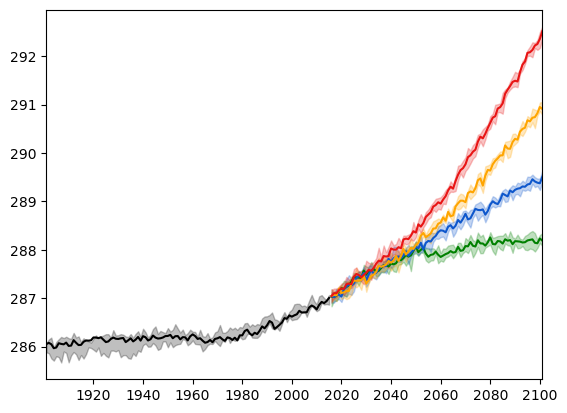

In [4]:
fig, ax = plt.subplots()

colors = {
    "ssp126": "green",
    "ssp245": "#0e57cc",
    "ssp370": "orange",
    "ssp585": "#e81515",
}

for scenario_da in scenarios["scenario"]:
    sc = scenario_da.item()
    ax.plot(
        scenarios_mean.sel(scenario=sc).resample(time="YE").mean().time,
        scenarios_mean.sel(scenario=sc).resample(time="YE").mean(),
        color=colors[sc])
    ax.fill_between(
        q.time,
        q.sel(scenario=sc, quantile=.05),
        q.sel(scenario=sc, quantile=.95),
        color=colors[sc], alpha=.25)

qh = historical_mean_spatial.sel(variant_label=[b'r3i1p1f2', b'r4i1p1f2', b'r5i1p1f2', b'r6i1p1f2']).resample(time="YE").mean().quantile([.05, .95], dim=["variant_label"])
ax.plot(
    historical_mean.resample(time="YE").mean().sel(time=slice("19000101", None)).time,
    historical_mean.resample(time="YE").mean().sel(time=slice("19000101", None)),
    color="black")
ax.fill_between(
    qh.sel(time=slice("19000101", None)).time,
    qh.sel(time=slice("19000101", None)).sel(quantile=.05),
    qh.sel(time=slice("19000101", None)).sel(quantile=.95),
    color="black", alpha=.25)

plt.margins(x=0)

Better model.

In [6]:
ssp119.dims, ssp585.dims

(FrozenMappingWarningOnValuesAccess({'lat': 64, 'bnds': 2, 'lon': 128, 'time': 1032, 'variant_label': 50, 'nfiles': 50, 'file': 2}),
 FrozenMappingWarningOnValuesAccess({'lat': 64, 'bnds': 2, 'lon': 128, 'time': 1032, 'variant_label': 50, 'nfiles': 52, 'file': 2}))

In [7]:
ssp119 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp119_Amon_gn_v20190429/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp119_Amon_tas_gn_v20190429.ncml").drop_dims(["nfiles", "file"]).chunk(variant_label=1, time=100)
ssp585 = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/Amon/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp585_Amon_gn_v20190429/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CCCma_CanESM5_ssp585_Amon_tas_gn_v20190429.ncml").drop_dims(["nfiles", "file"]).chunk(variant_label=1, time=100)

historical = xarray.open_dataset("https://hub.climate4r.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/Amon/CMIP6_CMIP_CCCma_CanESM5_historical_Amon_gn_v20190429/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CCCma_CanESM5_historical_Amon_tas_gn_v20190429.ncml").chunk(variant_label=1, time=100)
scenarios = xarray.concat([ssp119, ssp585], dim=xarray.Variable(["scenario"], ["ssp119", "ssp585"]))

In [ ]:
%%time

weights = np.cos(np.deg2rad(scenarios["lat"]))
mean_hist_1995_2014 = historical["tas"].sel(time=slice("19950101", "20141231")).weighted(weights).mean(["time", "lat", "lon"]).compute(num_worker=4)

historical_mean = historical["tas"].weighted(weights).mean(["variant_label", "lat", "lon"]).compute(num_worker=4)
scenarios_mean = scenarios["tas"].weighted(weights).mean(["variant_label", "lat", "lon"]).compute(num_worker=4)

historical_mean_spatial = historical["tas"].weighted(weights).mean(["lat", "lon"]).compute(num_worker=4)
scenarios_mean_spatial = scenarios["tas"].weighted(weights).mean(["lat", "lon"]).compute(num_worker=4)

In [15]:
q = scenarios_mean_spatial.resample(time="Y").mean().quantile([.05, .95], dim=["variant_label"])

In [26]:
len(scenarios["time"])

1032

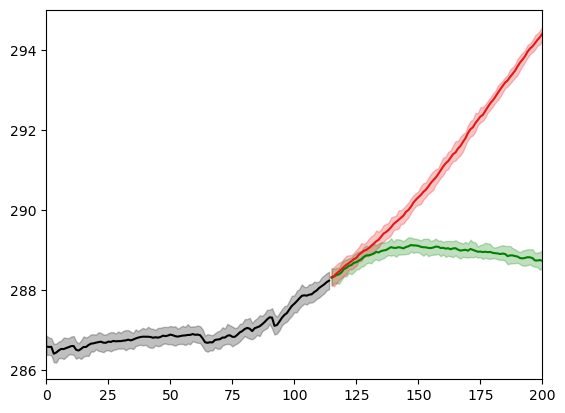

In [32]:
fig, ax = plt.subplots()

colors = {
    "ssp119": "green",
    "ssp245": "#0e57cc",
    "ssp370": "orange",
    "ssp585": "#e81515",
}
n_scenarios = len(scenarios_mean.sel(scenario=sc).resample(time="Y").mean().time)
n_historical = len(historical_mean.resample(time="Y").mean().sel(time=slice("19000101", None)))

for scenario_da in scenarios["scenario"]:
    sc = scenario_da.item()
    ax.plot(
        range(n_historical,n_historical+n_scenarios),
        scenarios_mean.sel(scenario=sc).resample(time="Y").mean(),
        color=colors[sc])
    ax.fill_between(
        range(n_historical,n_historical+n_scenarios),
        q.sel(scenario=sc, quantile=.05),
        q.sel(scenario=sc, quantile=.95),
        color=colors[sc], alpha=.25)

qh = historical_mean_spatial.resample(time="Y").mean().quantile([.05, .95], dim=["variant_label"])
ax.plot(
    range(n_historical),
    historical_mean.resample(time="Y").mean().sel(time=slice("19000101", None)),
    color="black")
ax.fill_between(
    range(n_historical),
    qh.sel(time=slice("19000101", None)).sel(quantile=.05),
    qh.sel(time=slice("19000101", None)).sel(quantile=.95),
    color="black", alpha=.25)

plt.margins(x=0)